# Import Packages

In [13]:
import pickle
import os
from datetime import datetime, timedelta
import requests
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, ParameterGrid, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy.stats import ttest_ind
from xgboost import XGBClassifier
import eli5
import shap
import matplotlib as mpl
import matplotlib.dates as mdates
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')

In [14]:
weather_data_main_future = pd.read_csv('01_mtb_weather_data_main_future_out.csv')

In [15]:
weather_data_main_future.columns

Index(['Unnamed: 0', 'date_clean', 'TMAX', 'AWND', 'PRCP', 'trail', 'PRCP_2d',
       'TMAX_2d', 'PRCP_3d', 'TMAX_3d', 'PRCP_7d', 'TMAX_7d'],
      dtype='object')

In [16]:
import joblib

# Load the dictionary of models
trail_models = joblib.load('02_trail_models.joblib')

# Make Predictions

In [17]:
# Function to classify confidence level
def classify_confidence_level(confidence):
    if confidence >= 0.90:
        return 'OPEN - VERY LIKELY'
    elif confidence >= 0.75:
        return 'OPEN - LIKELY'
    elif confidence >= 0.50:
        return 'UNSURE - LEANING OPEN'
    elif confidence >= 0.25:
        return 'UNSURE - LEANING CLOSED'
    elif confidence >= 0.10:
        return 'CLOSED - LIKELY'
    elif confidence < 0.10:
        return 'CLOSED - VERY LIKELY'
    else:
        return 'ERROR'

In [18]:
for trail, model in trail_models.items():
    trail_future_indices = weather_data_main_future["trail"] == trail
    trail_X_future = weather_data_main_future[trail_future_indices]
    model_features = [column for column in trained_features_order if column in trail_X_future.columns]

    missing_features = set(trained_features_order) - set(model_features)
    if missing_features:
        print(f"Trail: {trail}, Missing features: {missing_features}")

In [19]:
predictions = []

# Make sure 'date_clean' column is present in weather_data_main_future
weather_data_main_future['date_clean'] = pd.to_datetime(weather_data_main_future['date_clean'])

trained_features_order = ['AWND', 'PRCP', 'TMAX', 
'PRCP_2d', 'TMAX_2d', 
'PRCP_3d', 'TMAX_3d', 
# 'PRCP_4d', 'TMAX_4d', 
#  'PRCP_5d', 'TMAX_5d', 
#  'PRCP_6d', 'TMAX_6d', 
 'PRCP_7d', 'TMAX_7d']

for trail, model in trail_models.items():
    trail_future_indices = weather_data_main_future["trail"] == trail
    trail_X_future = weather_data_main_future[trail_future_indices]

    # Extract model features dynamically in correct order (all columns except "trail" and "date_clean")
    model_features = [column for column in trained_features_order if column in trail_X_future.columns]

    if not trail_X_future.empty:
        # Predict probability of the positive class instead of predicting class
        y_pred_proba = model.predict_proba(trail_X_future[model_features])[:, 1]
        confidence_level_class = np.vectorize(classify_confidence_level)(y_pred_proba)

        trail_predictions = pd.DataFrame({"Date": trail_X_future['date_clean'],
                                          "CORA Trail": trail, 
                                          "Chance of Being Open": y_pred_proba, 
                                          "Classification": confidence_level_class})
        predictions.append(trail_predictions)

predictions_df = pd.concat(predictions, ignore_index=True)
predictions_df


,Date,CORA Trail,Chance of Being Open,Classification
0,2023-07-26,Milford Trails,0.805760,OPEN - LIKELY
1,2023-07-27,Milford Trails,0.805760,OPEN - LIKELY
2,2023-07-28,Milford Trails,0.805760,OPEN - LIKELY
3,2023-07-29,Milford Trails,0.805760,OPEN - LIKELY
4,2023-07-30,Milford Trails,0.805760,OPEN - LIKELY
...,...,...,...,...
91,2023-07-29,Landen Deerfield,0.810847,OPEN - LIKELY
92,2023-07-30,Landen Deerfield,0.719783,UNSURE - LEANING OPEN
93,2023-07-31,Landen Deerfield,0.833515,OPEN - LIKELY
94,2023-08-01,Landen Deerfield,0.821326,OPEN - LIKELY


# Save & Write Out Predictions

In [22]:
import datetime as dt

# Create separate variables for the long and short date formats
now = dt.datetime.now()
execution_date_long = now.strftime('%Y-%m-%d %H:%M:%S')
execution_date = now.strftime('%Y-%m-%d')

results_df = predictions_df.copy()
results_df['Date'] = pd.to_datetime(results_df['Date']).dt.date
results_df['execution_date_long'] = execution_date_long
results_df['execution_date'] = execution_date

all_results = pd.DataFrame(columns=['Date', 'CORA Trail', 'Chance of Being Open', 'Classification', 'execution_date_long', 'execution_date'])

# Check if the output file exists
try:
    output_df = pd.read_csv('output_file_cora.csv')
except FileNotFoundError:
    # If the file doesn't exist, create a new file with headers
    all_results.to_csv('output_file_cora.csv', index=False)
    output_df = pd.read_csv('output_file_cora.csv')

all_results = all_results.append(results_df, ignore_index=True)

# Append the current run's results to the output file
output_df = output_df.append(results_df, ignore_index=True)

# Save the updated output file
output_df.to_csv('output_file_cora.csv', index=False)

output_df.head(3)

,Date,CORA Trail,Chance of Being Open,Classification,execution_date_long,execution_date
0,2023-07-21,Milford Trails,0.883325,OPEN - LIKELY,2023-07-21 17:36:54,2023-07-21
1,2023-07-22,Milford Trails,0.890087,OPEN - LIKELY,2023-07-21 17:36:54,2023-07-21
2,2023-07-23,Milford Trails,0.890087,OPEN - LIKELY,2023-07-21 17:36:54,2023-07-21


# Visualize Predicted Open/Closed Trails into future

In [24]:
output_df_no_dups = output_df.sort_values('execution_date_long', ascending = False).drop_duplicates(subset=['Date', 'CORA Trail'], keep='first')
# output_df_no_dups[output_df_no_dups['CORA Trail'] == 'Devou Park'].sort_values('execution_date_long', ascending = False)

In [29]:
from matplotlib import colors as mcolors
from datetime import date
from matplotlib.colors import ListedColormap, BoundaryNorm

# Primary Data Viz

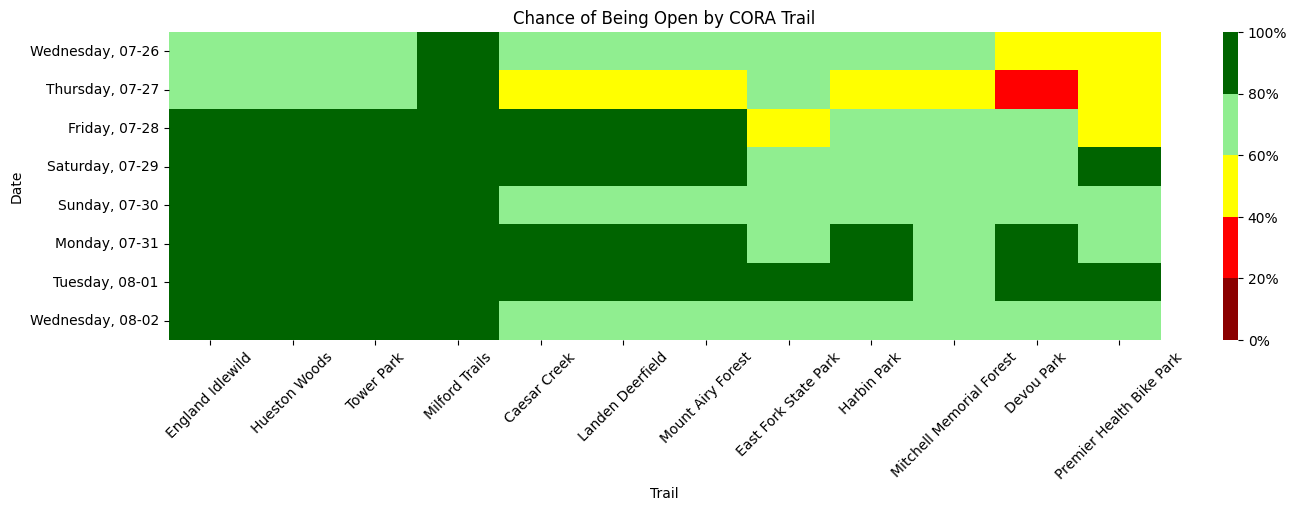

In [33]:
# No dups, take most recent prediction
output_df_no_dups = output_df.sort_values('execution_date_long', ascending = False).drop_duplicates(subset=['Date', 'CORA Trail'], keep='first')

# Convert 'Date' to datetime and sort
output_df_no_dups['Date'] = pd.to_datetime(output_df_no_dups['Date'], errors='coerce')

# Filter 'Date' by today or greater
today = pd.to_datetime(date.today())

from datetime import datetime, timedelta

# Subtract one day to get yesterday's date
yesterday = today - timedelta(days=1)

output_df_no_dups = output_df_no_dups[output_df_no_dups['Date'] >= today]

# Calculate mean 'Chance of Being Open' for each trail on each date
output_df_no_dups = output_df_no_dups.groupby(['Date', 'CORA Trail'], as_index=False).mean()

# Multiply 'Chance of Being Open' by 100
output_df_no_dups['Chance of Being Open'] = output_df_no_dups['Chance of Being Open'] * 100

# Create a new column 'Date_Str' for string formatted dates
output_df_no_dups['Date_Str'] = output_df_no_dups['Date'].dt.strftime('%A, %m-%d')

# Calculate average 'Chance of Being Open' for each trail
trail_avgs = output_df_no_dups.groupby('CORA Trail')['Chance of Being Open'].mean().sort_values(ascending=False)

# Pivot the DataFrame using 'Date' instead of 'Date_Str'
pivot_df = output_df_no_dups.pivot(index='Date', columns='CORA Trail', values='Chance of Being Open')

# Reorder the columns based on their average 'Chance of Being Open'
pivot_df = pivot_df[trail_avgs.index]

# Define custom colormap
cmap = mcolors.LinearSegmentedColormap.from_list("n",["red","yellow","green"])
# Define boundaries and colors
boundaries = [0, 20, 40, 60, 80, 100]  # Boundaries between color changes
colors = ["darkred", "red", "yellow", "lightgreen", "darkgreen"]  # Colors for each range

# Create colormap and norm
cmap = ListedColormap(colors)
norm = BoundaryNorm(boundaries, cmap.N, clip=True)

fig, ax = plt.subplots(figsize=(16,4))

# Use 'Date_Str' for y tick labels
sns.heatmap(pivot_df, cmap=cmap, norm=norm, ax=ax, cbar_kws={'format': '%.0f%%', 'boundaries': boundaries})

# Set yticklabels to the formatted string dates
ax.set_yticklabels(output_df_no_dups['Date_Str'].unique())

plt.title('Chance of Being Open by CORA Trail')
plt.ylabel('Date')
plt.xlabel('Trail')
plt.xticks(rotation=45)
plt.show()


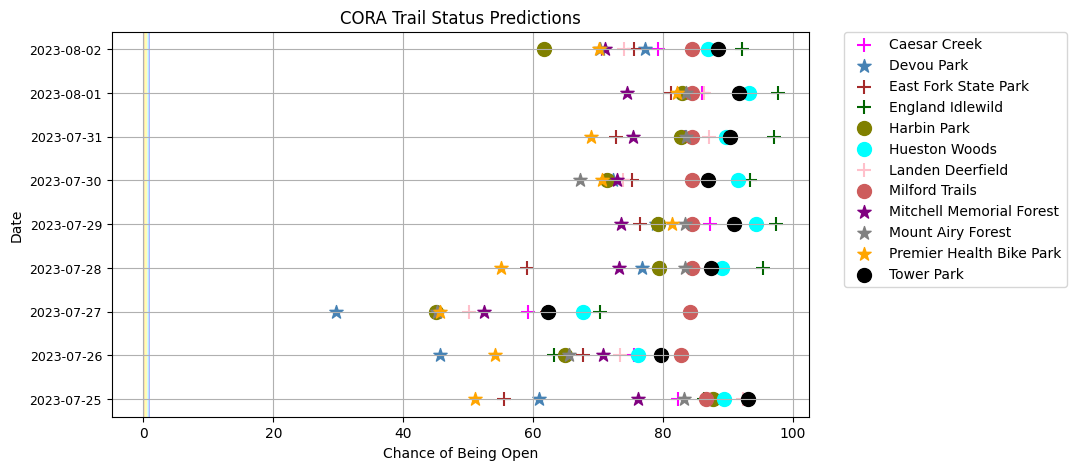

In [32]:
# Define a dictionary with unique markers that can be used for differentiating trails
trail_markers = {
    'Milford Trails': 'o',
    'England Idlewild': '+',
    'Premier Health Bike Park': '*',
    'Hueston Woods': 'o',
    'Caesar Creek': '+',
    'Devou Park': '*',
    'Tower Park': 'o',
    'Mitchell Memorial Forest': '*',
    'Landen Deerfield': '+',
    'East Fork State Park': '+',
    'Mount Airy Forest': '*',
    'Harbin Park': 'o',
}

trail_colors = {
    'Milford Trails': 'indianred',
    'England Idlewild': 'darkgreen',
    'Premier Health Bike Park': 'orange',
    'Hueston Woods': 'cyan',
    'Caesar Creek': 'magenta',
    'Devou Park': 'steelblue',
    'Tower Park': 'black',
    'Mitchell Memorial Forest': 'purple',
    'Landen Deerfield': 'pink',
    'East Fork State Park': 'brown',
    'Mount Airy Forest': 'gray',
    'Harbin Park': 'olive',
}

output_df_no_dups['Classification'] = output_df_no_dups['Chance of Being Open'].apply(classify_confidence_level)

fig, ax = plt.subplots(figsize=(9, 5))

# Strip the time portion from 'Date' column to avoid duplicate dates on y-axis
output_df_no_dups['Date'] = pd.to_datetime(output_df_no_dups['Date']).dt.date

# Define confidence cutoffs and corresponding colors for shading
cutoffs = [0.0, 0.10, 0.25, 0.50, 0.75, 0.90, 1.00]
colors = ['darkorange', 'orange', 'yellow', 'lightblue', 'deepskyblue', 'blue']

for i in range(len(cutoffs) - 1):
    plt.axvspan(cutoffs[i], cutoffs[i+1], facecolor=colors[i], alpha=0.3)

trails = output_df_no_dups['CORA Trail'].unique()

# Loop over each trail
for i, trail in enumerate(trails):
    # Choose a unique color and marker for each trail
    color = trail_colors[trail]
    marker = trail_markers[trail]
    trail_df = output_df_no_dups[output_df_no_dups['CORA Trail'] == trail]
    plt.scatter(trail_df['Chance of Being Open'], trail_df['Date'], 
                color=color, marker=marker, 
                label=trail, s=100)

plt.xlabel('Chance of Being Open')
plt.ylabel('Date')

ax.tick_params(axis='y', labelsize=9)

plt.title('CORA Trail Status Predictions')

# Formatting y-axis to display dates clearly
ax.yaxis.set_major_locator(mdates.DayLocator())  # Adjust as per your date range
ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.legend(loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.)  # Display a legend
plt.grid(True)
plt.show()